# 多尺度的锚框

In [59]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

img  = d2l.plt.imread('catdog.jpg')
h,w = img.shape[:2] [:2] #是 Python 中的切片操作，它取 shape 元组的前两个元素
h,w #h 和 w 代表的是图像的高度（height）和宽度（width）。


(561, 728)

In [60]:
# 在特征图上生成锚框 每个单位像素作为锚框的中心
def display_anchors(fmap_w, fmap_h, s):
    # 设置图像显示的尺寸
    d2l.set_figsize()

    # 创建一个形状为 (1, 10, fmap_h, fmap_w) 的全零特征图张量
    # 这里的 1 和 10 是随意设置的，主要目的是生成指定大小的特征图
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))

    # 使用特征图生成锚框
    # sizes=s 表示锚框的大小比例
    # ratios=[1, 2, 0.5] 表示锚框的宽高比
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])

    # 将图像宽度和高度转化为张量，便于后续的坐标缩放
    bbox_scale = torch.tensor((w, h, w, h))

    # 显示锚框
    # d2l.plt.imshow(img).axes 获取图像的坐标轴
    # anchors[0] * bbox_scale 对锚框坐标进行缩放，以适应实际图像大小
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

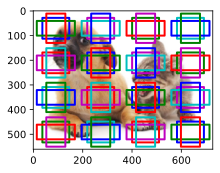

In [61]:
# 假设特征的宽是4 高是4 s =>锚框的尺寸为0.15
#生成锚框是img的锚框
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

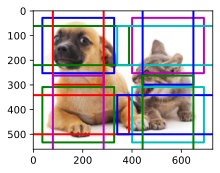

In [62]:
#我们将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标。 
#当尺度设置为0.4时，一些锚框将彼此重叠。
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

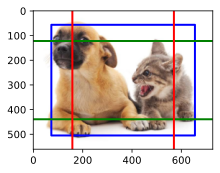

In [63]:
# 锚框只有1x1 将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8。 
# 此时，锚框的中心即是图像的中心
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

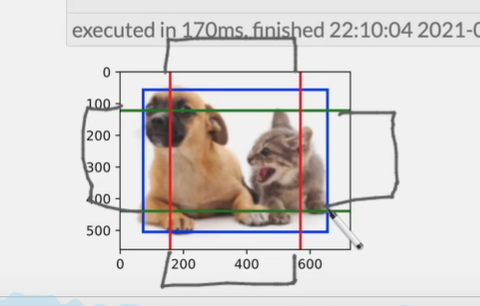

# 单发多框检测SSD

In [64]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 类别检测层

#定义了一个用于预测类别的卷积层函数用于生成物体检测模型中的类别预测器
def cls_predictor(num_inputs, num_anchors, num_classes):
    #输入通道数 每个像素点生成的锚框数量 需要预测的类别数量
    #+1即加一种背景类 预测的值即锚框数*（类+1）
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

# 这里返回的是一个 2D 卷积层 nn.Conv2d。
# num_inputs 是输入通道数，即输入特征图的通道数。
# num_anchors * (num_classes + 1) 是输出通道数，
# 表示每个锚框需要预测的类别数量加上背景类（总共 num_classes + 1 个类别）。
# kernel_size=3 表示卷积核的大小为 3x3。
# padding=1 表示在输入特征图的周围补一圈0，以保持输出特征图的空间维度与输入特征图相同。

In [65]:
# 边界预测层 返回一个 2D 卷积层，用于预测每个锚框的边界框
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

# num_inputs 是输入通道数，即输入特征图的通道数。
# num_anchors * 4 是输出通道数
# 表示每个锚框需要预测的边界框参数数量
# （通常为4个参数：中心坐标 (x, y)、宽度 (width) 和高度 (height)）。
# kernel_size=3 表示卷积核的大小为 3x3。
# padding=1 表示在输入特征图的周围补一圈0，以保持输出特征图的空间维度与输入特征图相同。

In [66]:
# 连接多尺度的预测
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape
# 输出的形状是（批量大小，通道数，高度，宽度）

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [67]:
def flatten_pred(pred):
    # 先将预测张量的通道维度移到最后，然后展平成二维张量
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
    # 将多个预测张量展平并沿第二个维度连接
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [68]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [69]:
# 高和宽减半块
#in_channels：输入特征图的通道数  out_channels：输出特征图的通道数
def down_sample_blk(in_channels, out_channels):
    # 创建一个空列表，用于存储各个层
    blk = []
    
    # 循环两次，添加卷积层、批归一化层和ReLU激活函数
    for _ in range(2):
        # 添加卷积层，使用3x3的卷积核，padding为1，以保持特征图尺寸不变
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        # 添加批归一化层
        blk.append(nn.BatchNorm2d(out_channels))
        # 添加ReLU激活函数
        blk.append(nn.ReLU())
        # 更新输入通道数
        in_channels = out_channels
    
    # 添加最大池化层，使用2x2的池化窗口，步幅为2，减半特征图尺寸
    blk.append(nn.MaxPool2d(2))
    
    # 将列表中的层组合成一个顺序容器并返回
    return nn.Sequential(*blk)



In [70]:
blk = down_sample_blk(3, 10)
print(blk)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [71]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [72]:
# 基本网络块
def base_net():
    # 创建一个空列表，用于存储各个层
    blk = []
    # 定义每个卷积块的输入和输出通道数
    num_filters = [3, 16, 32, 64]
    # 遍历 num_filters 列表，构建多个下采样块
    for i in range(len(num_filters) - 1):
        # 添加一个下采样块，每个块将输入通道数转换为输出通道数
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    # 将列表中的块组合成一个顺序容器并返回
    return nn.Sequential(*blk)

In [73]:
net = base_net()
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=

In [74]:
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [75]:
# 完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于生成锚框，
# 又用于预测这些锚框的类别和偏移量。
# 在这五个模块中，
# 第一个是基本网络块，
# 第二个到第四个是高和宽减半块，
# 最后一个模块使用全局最大池将高度和宽度都降到1。


def get_blk(i):
    if i == 0:
        blk = base_net()#生成一个基础网络块
    elif i == 1:
        blk = down_sample_blk(64, 128)# down_sample_blk(64, 128) 函数，生成一个下采样块，并将其赋值给 blk。
        #这个下采样块将输入通道数 64 转换为输出通道数 128。
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
        #成一个自适应最大池化层，将输出特征图的大小调整为 (1, 1)
    else:
        #生成一个下采样块，并将其赋值给 blk。
        #这个下采样块将输入通道数 128 转换为输出通道数 128
        blk = down_sample_blk(128, 128)
    return blk

In [76]:
# 为每个块定义前向计算
# X: 输入张量（例如，一批图像的特征图）。
# blk: 网络块，用于处理输入张量。
# size: 锚框的尺寸。
# ratio: 锚框的宽高比。
# cls_predictor: 分类预测器，用于对特征图进行分类预测。
# bbox_predictor: 边界框预测器，用于对特征图进行边界框预测。
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    # 通过网络块 blk 传递输入 X
    Y = blk(X)
    
    # 在特征图 Y 上生成锚框
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    
    # 对特征图 Y 进行分类预测
    cls_preds = cls_predictor(Y)
    
    # 对特征图 Y 进行边界框预测
    bbox_preds = bbox_predictor(Y)
    
    # 返回特征图、锚框、分类预测和边界框预测
    return (Y, anchors, cls_preds, bbox_preds)

In [77]:
sizes = [[0.2, 0.272], 
         [0.37, 0.447], 
         [0.54, 0.619], 
         [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [78]:
#定义完整的模型
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 动态设置5个网络块、分类预测器和边界框预测器
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        # 初始化锚框、分类预测和边界框预测的存储列表
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # 通过每个网络块，生成锚框、分类预测和边界框预测
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # 合并所有层的锚框
        anchors = torch.cat(anchors, dim=1)
        # 合并所有层的分类预测并调整形状
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        # 合并所有层的边界框预测
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [79]:
# 创建一个模型实例 然后使用它执行前向计算
# 初始化 TinySSD 模型，设置类别数为1
net = TinySSD(num_classes=1)

# 创建一个模拟输入数据 X，形状为 (32, 3, 256, 256)
X = torch.zeros((32, 3, 256, 256))

# 通过模型得到锚框、分类预测和边界框预测
anchors, cls_preds, bbox_preds = net(X)

# 打印输出锚框的形状
print('output anchors:', anchors.shape)

# 打印输出分类预测的形状
print('output class preds:', cls_preds.shape)

# 打印输出边界框预测的形状
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [80]:
# 让我们读取 13.6节中描述的香蕉检测数据集。
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [81]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [82]:
#定义损失函数和评价函数
# 目标检测有两种类型的损失。 第一种有关锚框类别的损失：
# 我们可以简单地复用之前图像分类问题里一直使用的交叉熵损失函数来计算； 
# 第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。


# 定义分类损失函数和边界框损失函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

# 计算损失的函数
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """
    计算分类损失和边界框损失，并返回它们的和。
    
    参数：
    cls_preds: 分类预测，形状为 (batch_size, num_anchors, num_classes + 1)
    cls_labels: 分类标签，形状为 (batch_size, num_anchors)
    bbox_preds: 边界框预测，形状为 (batch_size, num_anchors, 4)
    bbox_labels: 边界框标签，形状为 (batch_size, num_anchors, 4)
    bbox_masks: 边界框掩码，形状为 (batch_size, num_anchors, 4)
    
    返回值：
    总损失，形状为 (batch_size,)
    """
    # 获取批量大小和类别数
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]

    # 计算分类损失
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)

    # 计算边界框损失
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    
    # 返回分类损失和边界框损失的和
    return cls + bbox


In [83]:
# 我们可以沿用准确率评价分类结果。 由于偏移量使用了
# 范数损失，我们使用平均绝对误差来评价边界框的预测结果。
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.37e-03, bbox mae 3.38e-03
8755.6 examples/sec on cuda:0


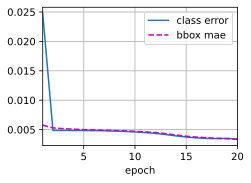

In [84]:
num_epochs, timer = 20, d2l.Timer()
# 创建一个动画器，用于显示训练过程中分类错误率和边界框MAE
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])

# 将模型移动到指定设备（CPU或GPU）
net = net.to(device)

# 开始训练循环
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)  # 创建一个累加器，用于累加指标

    net.train()  # 将模型设置为训练模式
    for features, target in train_iter:
        timer.start()  # 开始计时
        trainer.zero_grad()  # 梯度清零
        X, Y = features.to(device), target.to(device)  # 将输入和标签移动到设备
        
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        
        l.mean().backward()  # 反向传播计算梯度
        trainer.step()  # 更新模型参数
        
        # 评估分类预测和边界框预测
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    
    # 计算分类错误率和边界框MAE
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    
    # 更新动画器
    animator.add(epoch + 1, (cls_err, bbox_mae))

# 打印最终的分类错误率和边界框MAE
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on {str(device)}')

In [85]:
# 预测目标
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [86]:
# multibox_detection函数，我们可以根据锚框及其预测偏移量得到预测边界框。
# 然后，通过非极大值抑制来移除相似的预测边界框。

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

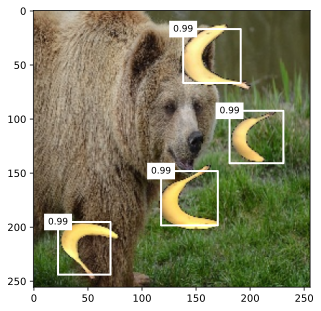

In [87]:
# 我们筛选所有置信度不低于0.9的边界框，做为最终输出
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

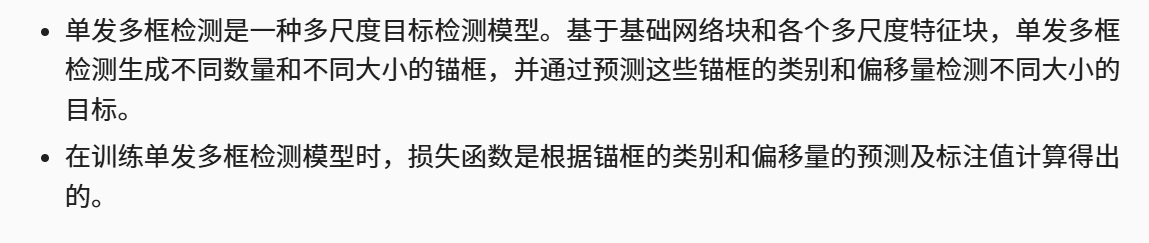

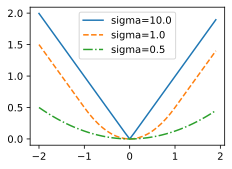

In [88]:
# 通过损失函数来改进单发多框检测
#将预测偏移量用到的L1范数损失替换为平滑L2范数损失
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

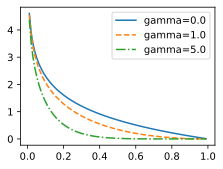

In [89]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();